In [82]:
import zipfile
import tarfile
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk

In [83]:
image = sitk.ReadImage('MRI/BraTS2021_00495_t2.nii.gz')

flair    (155, 240, 240)
seg    (155, 240, 240)
t1    (155, 240, 240)
t1ce    (155, 240, 240)
t2    (155, 240, 240)


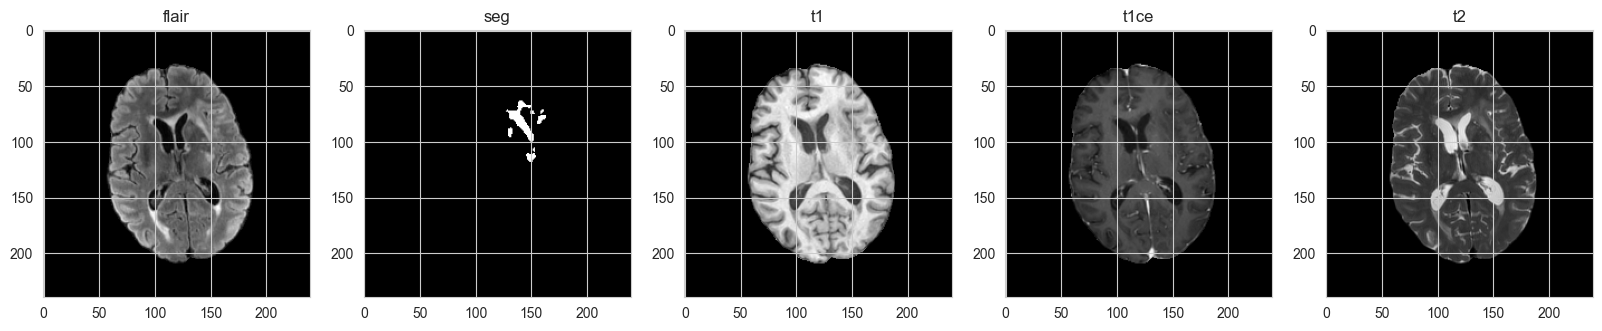

In [86]:
plt.rcParams['figure.figsize'] = (20,20)
for i,name in enumerate(['flair', 'seg', 't1', 't1ce', 't2'],1):
    image = sitk.ReadImage('MRI/BraTS2021_00621_{}.nii.gz'.format(name))
    img_arr = sitk.GetArrayFromImage(image)
    print(name, '  ', img_arr.shape)
    im = np.squeeze(img_arr[80])
    
    plt.subplot(1,5,i)
    plt.imshow(im, cmap='gray')
    plt.title(name)

(240, 240, 155)


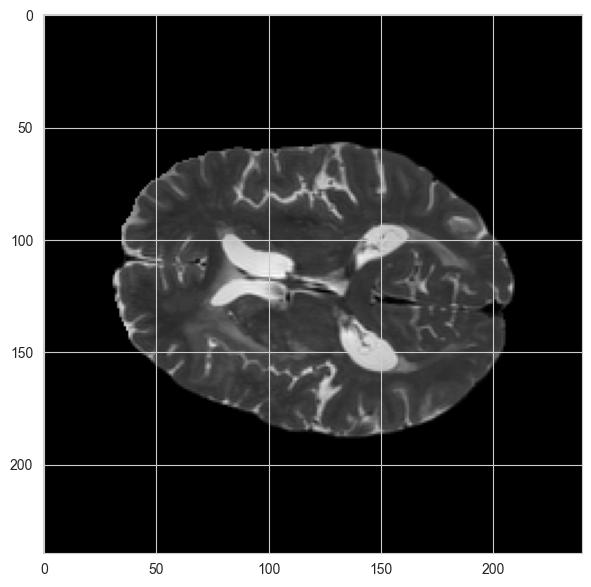

In [87]:
plt.rcParams['figure.figsize'] = (7,7)
nii_img  = nib.load('MRI/BraTS2021_00621_t2.nii.gz').get_fdata()
print(nii_img.shape)
plt.imshow(nii_img[:,:,80], cmap='gray')

(240, 240, 155)


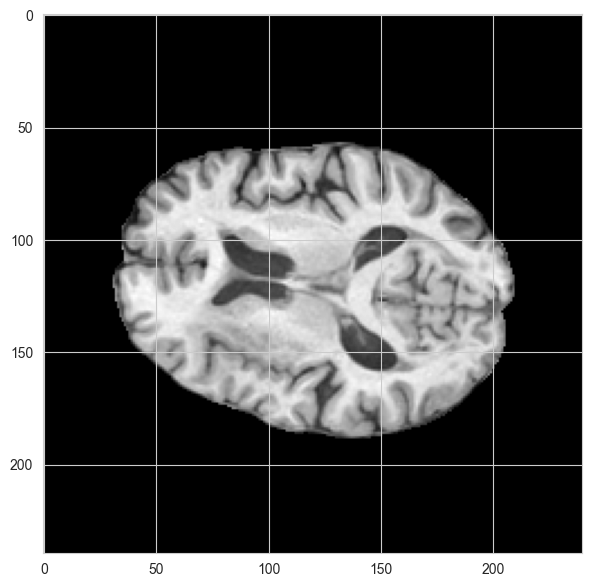

In [88]:
plt.rcParams['figure.figsize'] = (7,7)
nii_img  = nib.load('MRI/BraTS2021_00621_t1.nii.gz').get_fdata()
print(nii_img.shape)
plt.imshow(nii_img[:,:,80], cmap='gray')

In [89]:
from glob import glob

In [90]:
task1_files = glob('MRI/*')

In [91]:
len(task1_files)

12

In [92]:
import albumentations as A
import numpy as np


class ImageReader:
    def __init__(
        self, root:str, img_size:int=256,
        normalize:bool=False, single_class:bool=False
    ) -> None:
        pad_size = 256 if img_size > 256 else 224
        self.resize = A.Compose(
            [
                A.PadIfNeeded(min_height=pad_size, min_width=pad_size, value=0),
                A.Resize(img_size, img_size)
            ]
        )
        self.normalize=normalize
        self.single_class=single_class
        self.root=root
        
    def read_file(self, path:str) -> dict:
        scan_type = path.split('_')[-1]
        raw_image = nib.load(path).get_fdata()
        raw_mask = nib.load(path.replace(scan_type, 'seg.nii.gz')).get_fdata()
        processed_frames, processed_masks = [], []
        for frame_idx in range(raw_image.shape[2]):
            frame = raw_image[:, :, frame_idx]
            mask = raw_mask[:, :, frame_idx]
            resized = self.resize(image=frame, mask=mask)
            processed_frames.append(resized['image'])
            processed_masks.append(
                1*(resized['mask'] > 0) if self.single_class else resized['mask']
            )
        scan_data = np.stack(processed_frames, 0)
        if self.normalize:
            if scan_data.max() > 0:
                scan_data = scan_data/scan_data.max()
            scan_data = scan_data.astype(np.float32)
        return {
            'scan': scan_data,
            'segmentation': np.stack(processed_masks, 0),
            'orig_shape': raw_image.shape
        }
    
    def load_patient_scan(self, idx:int, scan_type:str='flair') -> dict:
        patient_id = str(idx).zfill(5)
        scan_filename = f'MRI/BraTS2021_00621_t1.nii.gz'
        return self.read_file(scan_filename)
            

In [93]:
reader = ImageReader('MRI/', img_size=128, normalize=True, single_class=False)

In [94]:
from skimage.morphology import binary_closing
import plotly.express as px

data = reader.load_patient_scan(0)

image = data['scan'][60]
masked_image = 1 * (image > 0)
filled_image = 1 * binary_closing(image)

px.imshow(
    np.array([image, masked_image, filled_image]),
    facet_col=0, title="Different image masking - none, threshold and binary closing",
)

In [95]:
def pix_count(scan:np.array, close:bool=False, mask:bool=False, mask_idx:int=-1) -> int:
    slice_areas = []
    for slice_idx in range(scan.shape[0]):
        if close:
            mri = 1 * binary_closing(scan[slice_idx, :, :])
        elif mask_idx >= 0:
            mri = 1 * (scan[slice_idx, :, :] == mask_idx)
        elif mask:
            mri = 1 * (scan[slice_idx, :, :] > 0)
        else:
            raise ValueError('Masking mechanism should be specified')
        mri_area = mri.sum()
        slice_areas.append(mri_area)
    return np.sum(slice_areas)

pix_count(data['segmentation'], mask=True) / pix_count(data['scan'], mask=True)

0.017031667740199236

In [96]:
def get_centroid(scan:np.array, mask_idx:int=1) -> list:
    z, x, y = (scan == mask_idx).nonzero()
    x, y, z = np.median(x), np.median(y), np.median(z)
    return [x/scan.shape[1], y/scan.shape[2], z/scan.shape[0]]

get_centroid(data['segmentation'], 4), get_centroid(data['segmentation'], 1)

([0.59375, 0.390625, 0.3225806451612903], [nan, nan, nan])

In [97]:
import cv2
import tensorflow as tf

In [98]:
images_path = 'Data/BraTS2021'

In [99]:
import nibabel as nib
import os
import albumentations as A
import numpy as np

In [100]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

In [101]:
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

In [102]:
data_path = [f.path for f in os.scandir(images_path ) if f.is_dir()]

def data_list(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

data_id = data_list(data_path); 

   
train_files, val_ = train_test_split(data_id,test_size=0.2) 
val_files, test_files = train_test_split(val_, test_size=0.15) 

In [103]:
IMG_SIZE=128

In [104]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        # Generate data
        for c, i in enumerate(Batch_ids):
            # Construct the correct case path by ensuring both the folder and file name are used
            case_folder = os.path.join(images_path, os.path.basename(i))  # e.g., 'Data/BraTS2021/BraTS2021_00565'
            case_path = os.path.join(case_folder, os.path.basename(i))    # e.g., 'Data/BraTS2021/BraTS2021_00565/BraTS2021_00565'

            print(f"Batch {Batch_ids}")
            print(f"Case Path: {case_path}")
            print(f"Processed patient: {c}")

            # Load modalities and segmentation
            flair_path = f'{case_path}_flair.nii'
            flair = nib.load(flair_path).get_fdata()

            ce_path = f'{case_path}_t1ce.nii'
            ce = nib.load(ce_path).get_fdata()

            seg_path = f'{case_path}_seg.nii'
            seg = nib.load(seg_path).get_fdata()

            # Process slices for each modality
            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]


        # Generate masks
        y[y == 4] = 3  # Adjust class values as needed
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        return X / np.max(X), Y


# Initialize the data generators
training_generator = DataGenerator(train_files)
valid_generator = DataGenerator(val_files)
test_generator = DataGenerator(test_files)


C:\Users\binwa\AppData\Local\Temp\ipykernel_860\2972652581.py:4: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



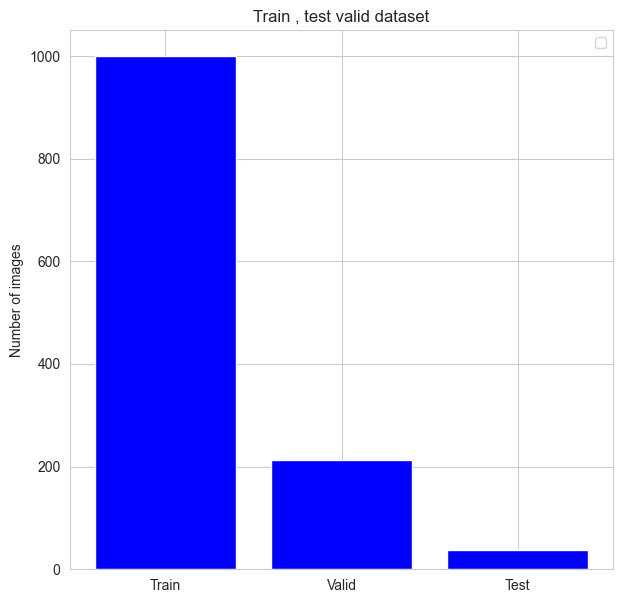

In [105]:
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_files), len(val_files), len(test_files)], align='center',color=[ 'blue','blue', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Train , test valid dataset')

    plt.show()
    
showDataLayout()

In [106]:
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten

In [107]:
from keras.models import Model, load_model
from keras.layers import Input ,BatchNormalization , Activation 
from keras.layers import Conv2D, UpSampling2D
from keras.layers import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [108]:
from keras.layers import concatenate

In [109]:
def cnn_vit_bottleneck(cnn_output, patch_size=8, embed_dim=256):
    """
    Tokenizes the CNN output into patches suitable for the ViT.
    Args:
        cnn_output: Output feature map from the CNN (before the ViT bottleneck).
        patch_size: Size of each patch (should match the input size of the ViT).
        embed_dim: Embedding dimension for the transformer (must match transformer).
    Returns:
        tokens: Flattened patches to be passed to the transformer.
    """
    # Reshape CNN output to patches
    patches = tf.image.extract_patches(
        images=cnn_output,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='SAME'
    )

    # Flatten the patches into tokens
    patches = tf.reshape(patches, [tf.shape(cnn_output)[0], -1, patch_size * patch_size * cnn_output.shape[-1]])

    # Project patches into transformer embedding dimension
    tokens = Dense(embed_dim)(patches)
    
    return tokens


In [110]:
def vit_transformer_block(tokens, embed_dim=256, num_heads=8, ff_dim=512, dropout_rate=0.1):
    """
    Vision Transformer block with multi-head self-attention and feed-forward layers.
    Args:
        tokens: Flattened patches (tokens) to be passed through the transformer.
        embed_dim: Embedding dimension for the transformer.
        num_heads: Number of attention heads.
        ff_dim: Feed-forward network dimension.
        dropout_rate: Dropout rate for regularization.
    Returns:
        transformer_output: The output of the transformer block.
    """
    # Layer normalization
    x = LayerNormalization()(tokens)

    # Multi-head self-attention layer
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    attention_output = Dropout(dropout_rate)(attention_output)

    # Add & Normalize (residual connection)
    x = Add()([attention_output, x])
    x = LayerNormalization()(x)

    # Feed-forward network (FFN)
    ffn_output = Dense(ff_dim, activation='relu')(x)
    ffn_output = Dense(embed_dim)(ffn_output)  # Ensure embedding dim matches the input
    ffn_output = Dropout(dropout_rate)(ffn_output)

    # Add & Normalize (residual connection)
    transformer_output = Add()([ffn_output, x])

    return transformer_output


In [111]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Dropout

def transformer_block(x, num_heads, ff_dim, dropout_rate=0.1):
    # Self-Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)
    attention_output = Dropout(dropout_rate)(attention_output)
    # Add & Normalize
    x = LayerNormalization(epsilon=1e-6)(x + attention_output)

    # Feed-forward network
    ff_output = Dense(ff_dim, activation='relu')(x)
    ff_output = Dropout(dropout_rate)(ff_output)
    # Add & Normalize
    x = LayerNormalization(epsilon=1e-6)(x + ff_output)
    
    return x

def deep_CNN_u_with_ViT(inputs, ker_init, dropout, num_heads=4, ff_dim=512):
    # Encoder (Same as your existing U-Net)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    # Bottleneck with Transformer Block
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)
    
    # Transformer integration (Add Multi-Head Attention and Layer Normalization)
    transformer_out = transformer_block(drop5, num_heads=num_heads, ff_dim=ff_dim)
    
    # Decoder (Same as your existing U-Net)
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(transformer_out))
    merge7 = concatenate([conv3, up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv, up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1, up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

# Input layer and model creation
input_layer = Input((128, 128, 2))  # Input is same (128x128, 2 channels)
model_with_ViT = deep_CNN_u_with_ViT(input_layer, 'he_normal', 0.2)

# Compile the model with the same metrics and loss function



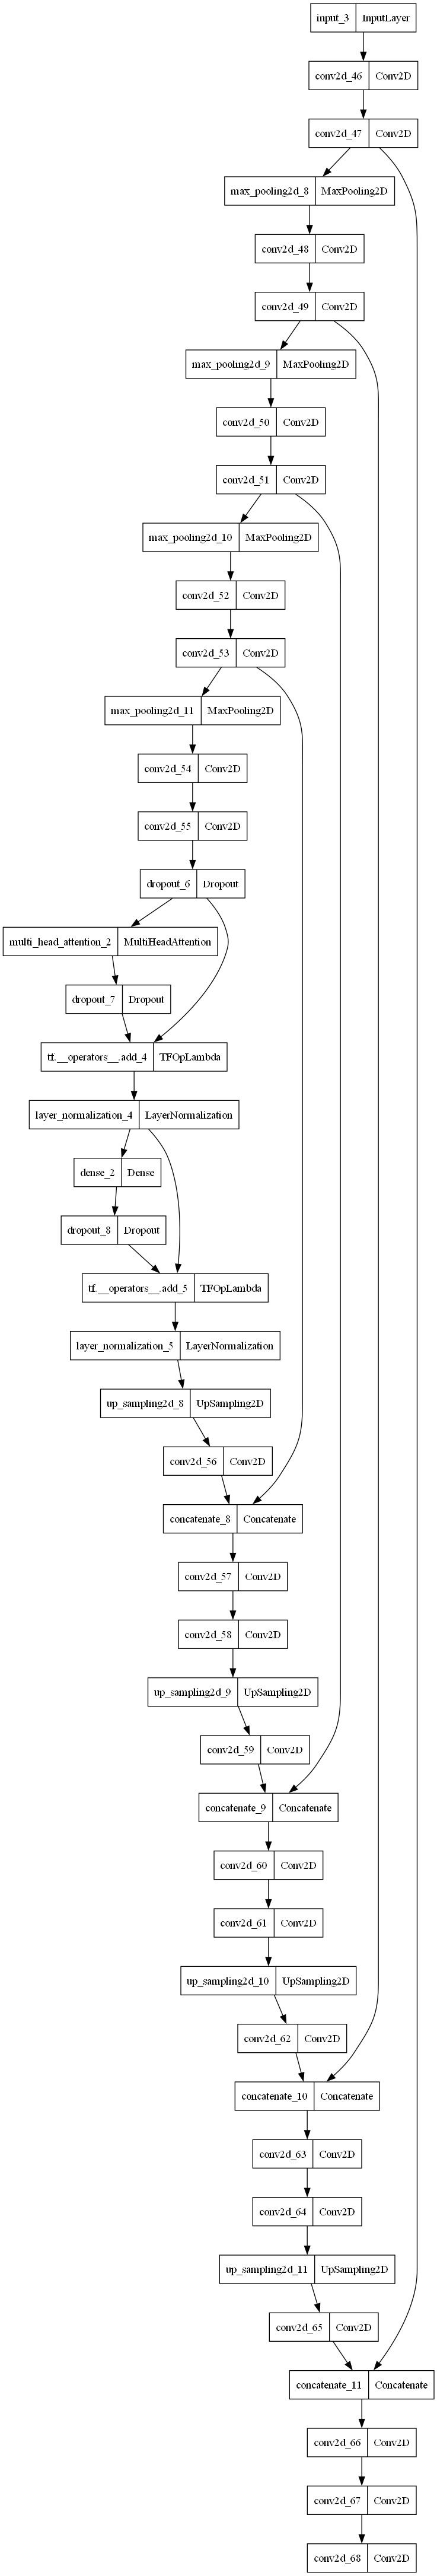

In [112]:
plot_model(model_with_ViT)

In [113]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE',
    2 : 'EDEMA',
    3 : 'ENHANCING' 
}
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 

In [114]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [115]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [116]:
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [117]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

In [118]:
model_with_ViT.compile(
    loss="categorical_crossentropy", 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity]
)

In [ ]:
history_with_ViT = model_with_ViT.fit(
    training_generator,
    epochs=50
    validation_data=valid_generator
)


In [ ]:
# Save the entire model after training
model_with_ViT.save('Models/Trained_CNN_Model.h5')  # You can choose any filename, e.g., 'my_model.h5'


/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



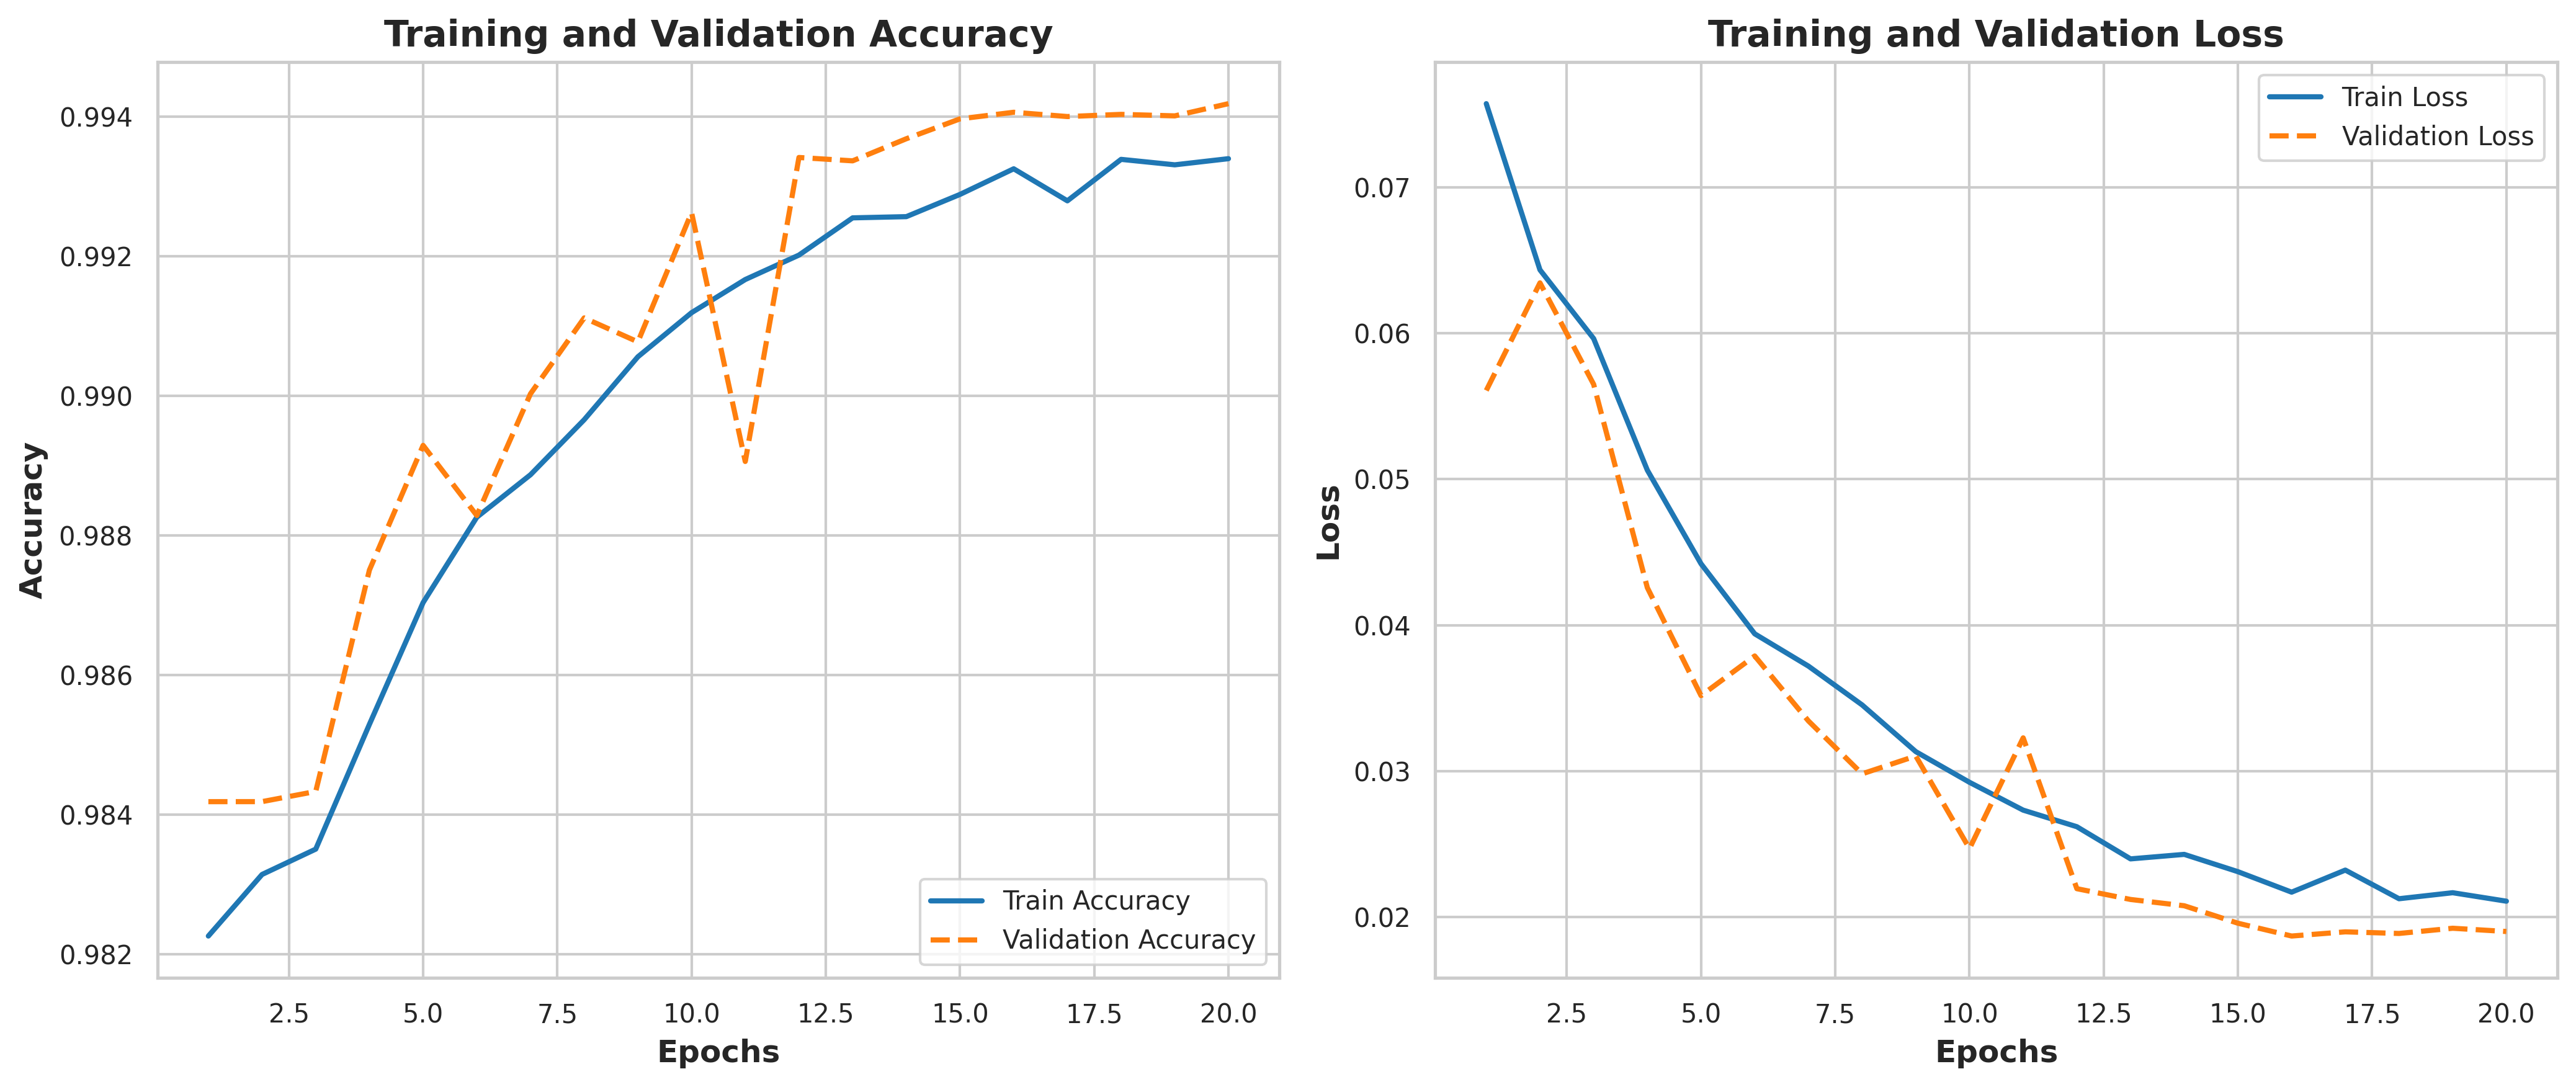

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use Seaborn style
sns.set(style="whitegrid")

# Define epochs
epochs = list(range(1, 20 + 1))

# Retrieve accuracy and loss values
acc = history_with_ViT.history['accuracy']
val_acc = history_with_ViT.history['val_accuracy']
loss = history_with_ViT.history['loss']
val_loss = history_with_ViT.history['val_loss']

# Set figure size and DPI for high-quality output
plt.figure(figsize=(14, 6), dpi=300)

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Accuracy', color='#1f77b4', linewidth=2.0)
plt.plot(epochs, val_acc, label='Validation Accuracy', color='#ff7f0e', linestyle='--', linewidth=2.0)
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss', color='#1f77b4', linewidth=2.0)
plt.plot(epochs, val_loss, label='Validation Loss', color='#ff7f0e', linestyle='--', linewidth=2.0)
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Save the figure in high quality
plt.tight_layout()
plt.savefig('Visualization/Train_Val_Accuracy_Loss_HighQuality.png', bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
loss = history_with_ViT.history['loss']
val_loss = history_with_ViT.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.savefig('Visualization/Train_Val_Loss.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
import pandas as pd

# Extract metrics from training history
  # Adjust if you have stored it in another variable

epochs = list(range(1, len(history_with_ViT['accuracy']) + 1))

# Creating a DataFrame to present these metrics in a table format
metrics_table = pd.DataFrame({
    'Epoch': epochs,
    'Accuracy': history_with_ViT['accuracy'],
    'Val Accuracy': history_with_ViT['val_accuracy'],
    'Mean IoU': history_with_ViT['mean_io_u'],
    'Val Mean IoU': history_with_ViT['val_mean_io_u'],
    'Dice Coefficient': history_with_ViT['dice_coef'],
    'Val Dice Coefficient': history_with_ViT['val_dice_coef'],
    'Precision': history_with_ViT['precision'],
    'Val Precision': history_with_ViT['val_precision'],
    'Sensitivity': history_with_ViT['sensitivity'],
    'Val Sensitivity': history_with_ViT['val_sensitivity'],
    'Specificity': history_with_ViT['specificity'],
    'Val Specificity': history_with_ViT['val_specificity'],
})

# Print the DataFrame
print(metrics_table)


    Epoch  Accuracy  Val Accuracy  Mean IoU  Val Mean IoU  Dice Coefficient  \
0       1  0.982262      0.984187  0.529026      0.486290          0.280741   
1       2  0.983144      0.984187  0.566156      0.375599          0.297850   
2       3  0.983507      0.984332  0.594898      0.375693          0.319449   
3       4  0.985294      0.987503  0.430981      0.785977          0.371952   
4       5  0.987037      0.989289  0.695808      0.772437          0.413711   
5       6  0.988260      0.988284  0.701492      0.811099          0.449197   
6       7  0.988868      0.990028  0.663276      0.808350          0.480717   
7       8  0.989656      0.991114  0.683772      0.376059          0.506599   
8       9  0.990557      0.990771  0.754276      0.814645          0.541227   
9      10  0.991189      0.992622  0.789228      0.815288          0.564064   
10     11  0.991664      0.989058  0.783811      0.806678          0.574973   
11     12  0.992014      0.993411  0.777668      0.8

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Confusion matrix data (normalized)
# confusion_matrix_data = np.array([
#     [1.00, 0.00, 0.00, 0.00],
#     [0.03, 0.89, 0.04, 0.05],
#     [0.03, 0.03, 0.90, 0.04],
#     [0.05, 0.01, 0.02, 0.92]
# ])


# # Class labels
# class_labels = ["Background", "Tumor Core", "Edema", "Enhancing Tumor"]

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_matrix_data, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, fmt=".2f")
# plt.title("Normalized Confusion Matrix for Brain Tumor Segmentation")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)

# # Save the figure (optional)
# plt.savefig("normalized_confusion_matrix.png", bbox_inches='tight')
# plt.show()


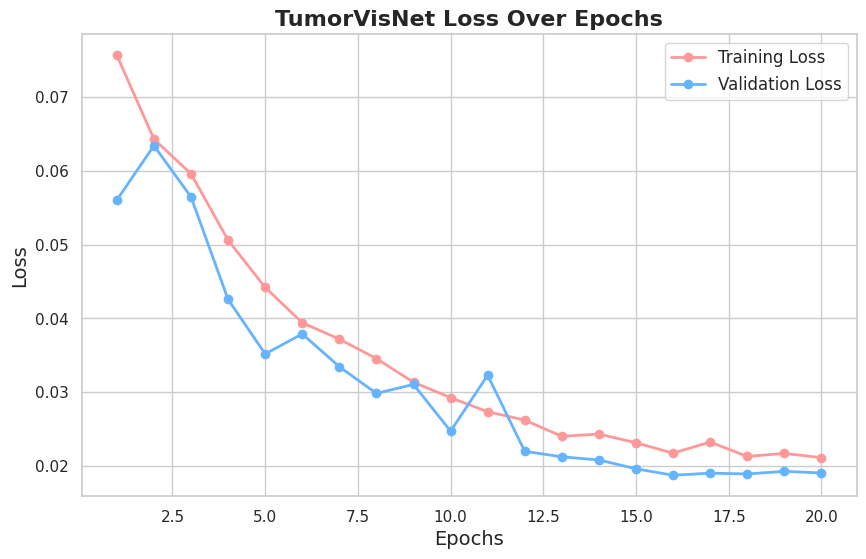

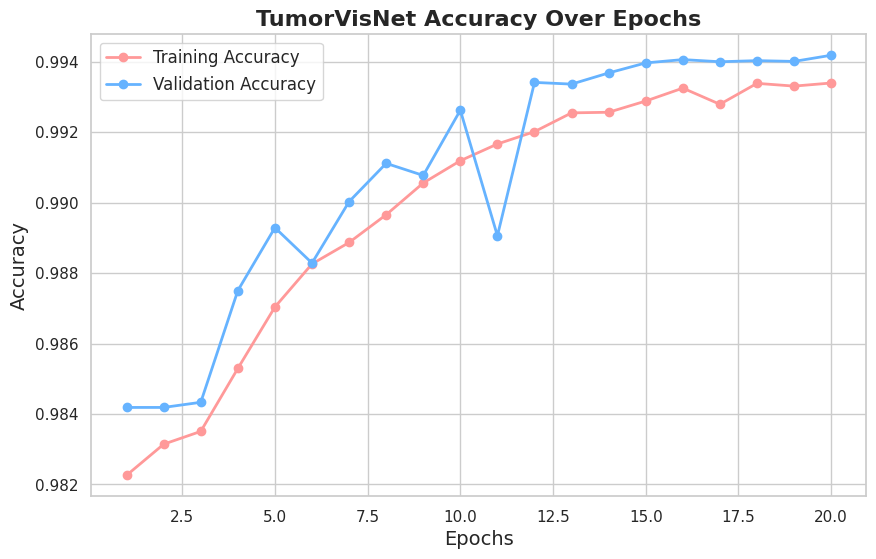

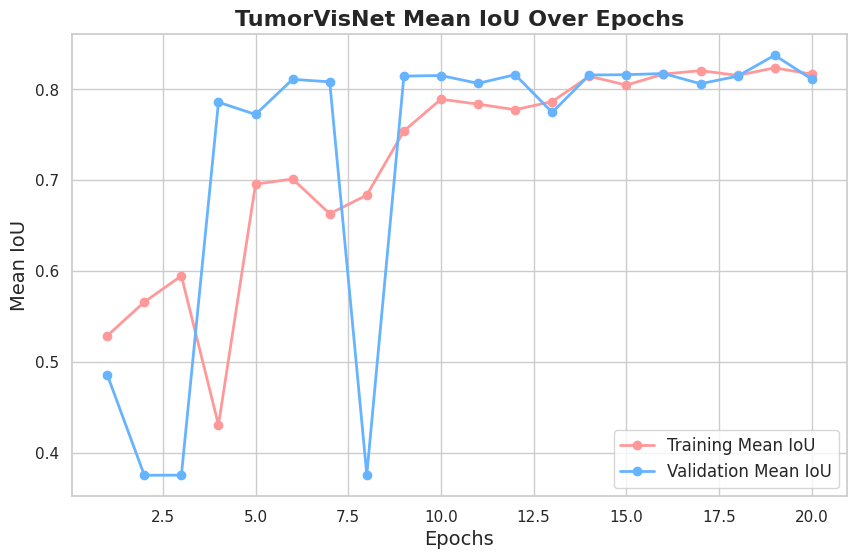

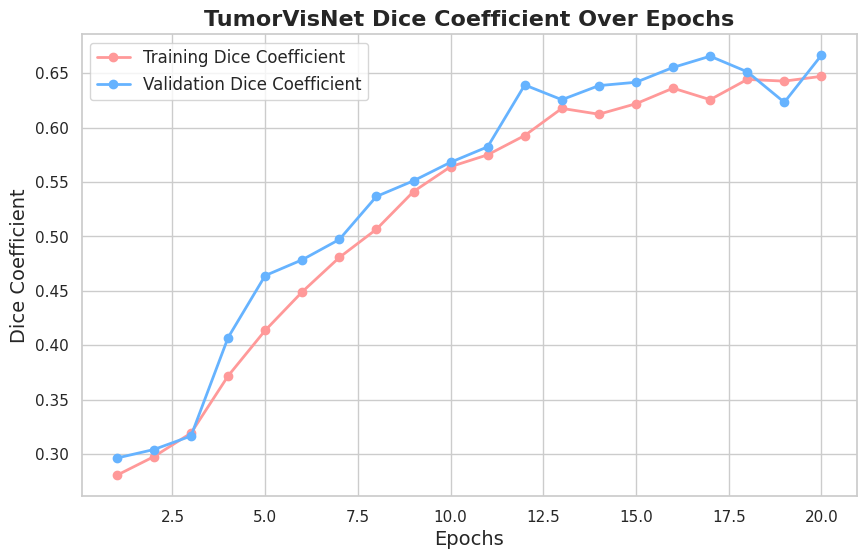

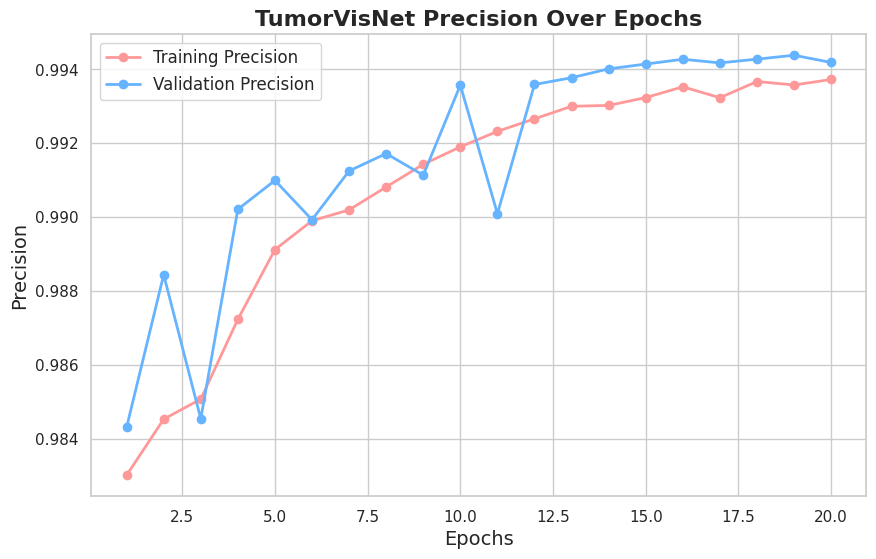

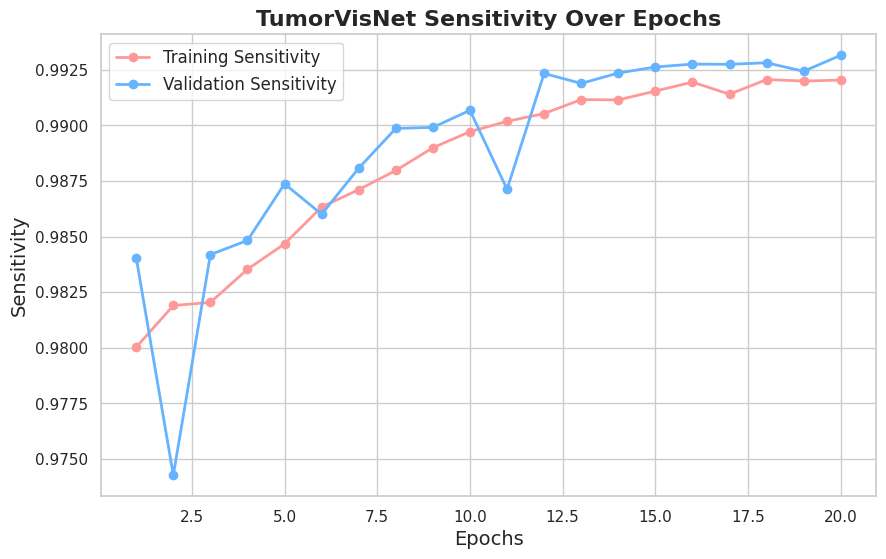

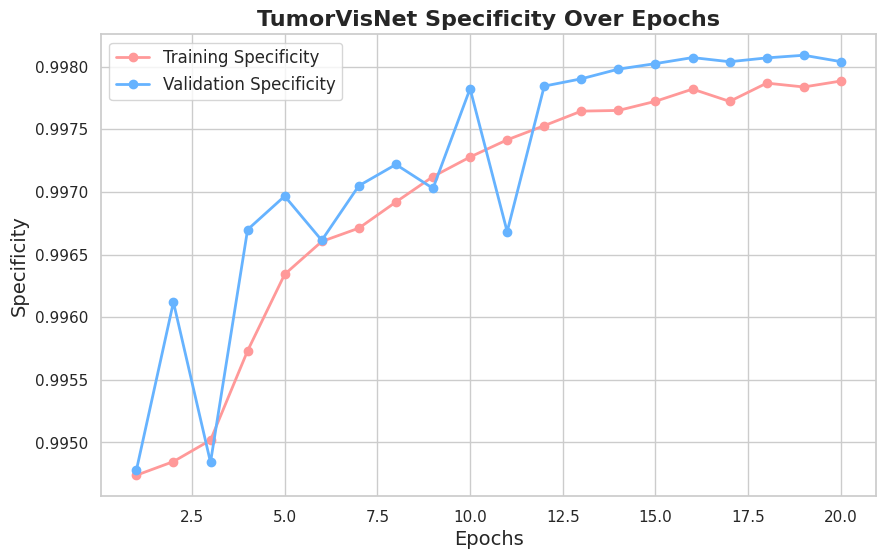

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Customize colors and plot appearance
sns.set_style("whitegrid")
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']

def plot_custom_metric(metric_name, train_values, val_values, epochs, save_path):
    plt.figure(figsize=(10, 6))
    
    # Plot training and validation curves
    plt.plot(epochs, train_values, label=f'Training {metric_name}', color=colors[0], linewidth=2, marker='o')
    plt.plot(epochs, val_values, label=f'Validation {metric_name}', color=colors[1], linewidth=2, marker='o')
    
    # Customize plot appearance
    plt.title(f'TumorVisNet {metric_name} Over Epochs', fontsize=16, fontweight='bold')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    
    # Save the plot as an image file
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

# Define epochs list
epochs = list(range(1, 20 + 1))

# Plot and save all the metrics
plot_custom_metric("Loss", history_with_ViT['loss'], history_with_ViT['val_loss'], epochs, "Visualization/VitUnet_loss_plot.png")
plot_custom_metric("Accuracy", history_with_ViT['accuracy'], history_with_ViT['val_accuracy'], epochs, "Visualization/VitUnet_accuracy_plot.png")
plot_custom_metric("Mean IoU", history_with_ViT['mean_io_u'], history_with_ViT['val_mean_io_u'], epochs, "Visualization/VitUnet_mean_iou_plot.png")
plot_custom_metric("Dice Coefficient", history_with_ViT['dice_coef'], history_with_ViT['val_dice_coef'], epochs, "Visualization/VitUnet_dice_plot.png")
plot_custom_metric("Precision", history_with_ViT['precision'], history_with_ViT['val_precision'], epochs, "Visualization/VitUnet_precision_plot.png")
plot_custom_metric("Sensitivity", history_with_ViT['sensitivity'], history_with_ViT['val_sensitivity'], epochs, "Visualization/VitUnet_sensitivity_plot.png")
plot_custom_metric("Specificity", history_with_ViT['specificity'], history_with_ViT['val_specificity'], epochs, "Visualization/VitUnet_specificity_plot.png")


Processing BraTS2021_00495...
5/5 [==============================] - 1s 229ms/step


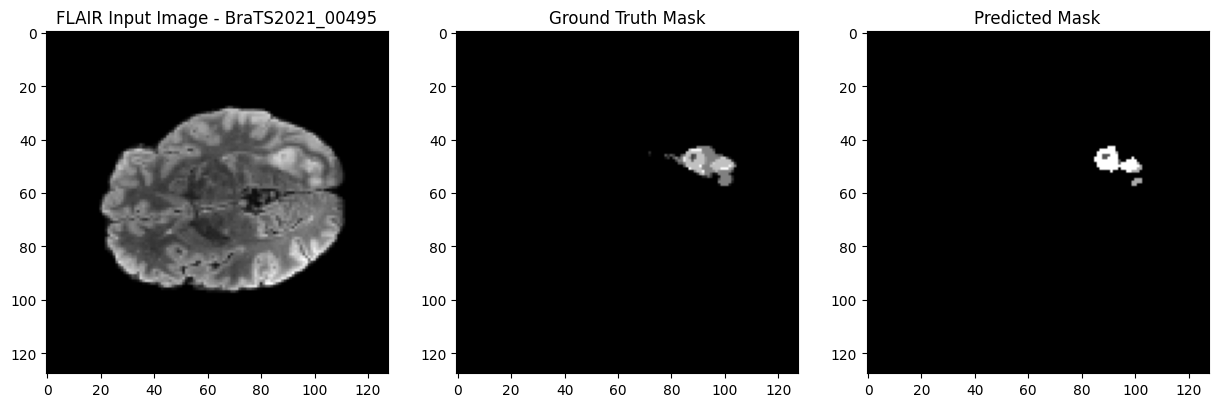

Processing BraTS2021_00621...
5/5 [==============================] - 1s 224ms/step


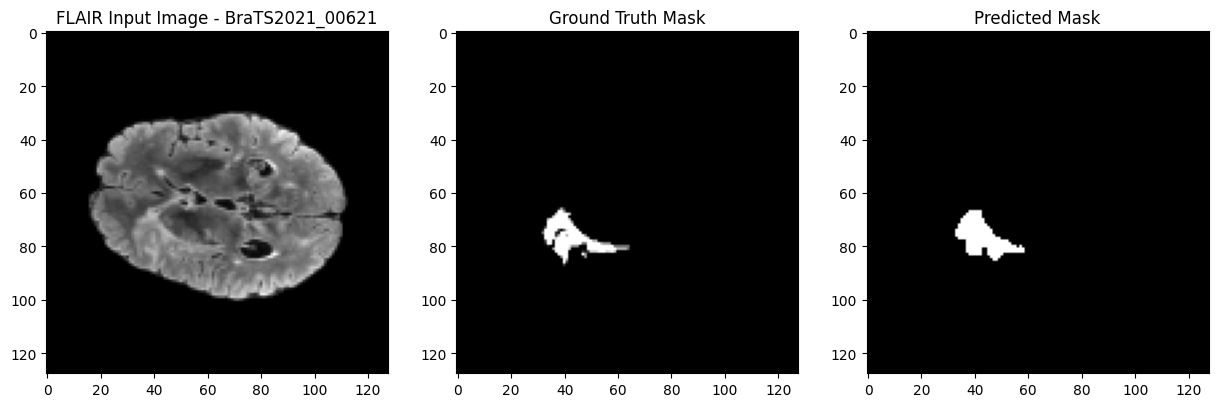

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import nibabel as nib

# Define constants
IMG_SIZE = 128
VOLUME_SLICES = 155  # Maximum number of slices per volume
VOLUME_START_AT = 0  # Starting at the first slice for prediction
n_channels = 2  # Number of MRI channels (e.g., FLAIR, T1CE)
num_classes = 4  # Number of classes for segmentation

# Load the saved model
model_with_ViT = load_model('Models/Trained_CNN_Model.h5', compile=False)

# Function to load new patient data
def load_patient_data(patient_folder):
    X = np.zeros((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, n_channels))
    Y = np.zeros((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))  # Ground truth

    # Load each modality (FLAIR, T1CE)
    flair_path = os.path.join('MRI', patient_folder, f'{patient_folder}_flair.nii')
    t1ce_path = os.path.join('MRI', patient_folder, f'{patient_folder}_t1ce.nii')
    seg_path = os.path.join('MRI', patient_folder, f'{patient_folder}_seg.nii')

    flair = nib.load(flair_path).get_fdata()
    t1ce = nib.load(t1ce_path).get_fdata()
    seg = nib.load(seg_path).get_fdata()

    total_slices = flair.shape[2]  # Number of available slices

    # Resize and load data into X and Y arrays
    for j in range(min(VOLUME_SLICES, total_slices)):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(t1ce[:, :, j], (IMG_SIZE, IMG_SIZE))
        Y[j] = cv2.resize(seg[:, :, j], (IMG_SIZE, IMG_SIZE))

    # Normalize inputs
    X = X / (np.max(X) + 1e-8)

    # Adjust labels for segmentation
    Y[Y == 4] = 3  # Adjust class values if needed

    return X, Y

# Function to visualize prediction vs ground truth
def visualize_prediction(patient_data, ground_truth, prediction, slice_num, modality_name, patient_name):
    plt.figure(figsize=(15, 5))

    # Input MRI (any modality, e.g., FLAIR)
    plt.subplot(1, 3, 1)
    plt.imshow(patient_data[slice_num, :, :, 0], cmap='gray')
    plt.title(f'{modality_name} Input Image - {patient_name}')

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth[slice_num], cmap='gray')
    plt.title('Ground Truth Mask')

    # Prediction
    plt.subplot(1, 3, 3)
    predicted_mask = np.argmax(prediction[slice_num], axis=-1)  # Convert one-hot back to mask
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.savefig(f'Visualization/{patient_name}_Prediction.png', bbox_inches='tight', dpi=300)
    plt.show()

# Load new patient data and make predictions
patient_folders = ['BraTS2021_00495', 'BraTS2021_00621']  # Assuming the MRI folders are named this way

for patient_folder in patient_folders:
    print(f"Processing {patient_folder}...")

    # Load patient data
    patient_data, ground_truth = load_patient_data(patient_folder)

    # Make prediction
    prediction = model_with_ViT.predict(patient_data)

    # Visualize the prediction vs ground truth for one slice
    slice_num = 70  # Select a slice to visualize
    visualize_prediction(patient_data, ground_truth, prediction, slice_num, "FLAIR", patient_folder)


5/5 [==============================] - 1s 221ms/step


<Figure size 1800x5000 with 0 Axes>

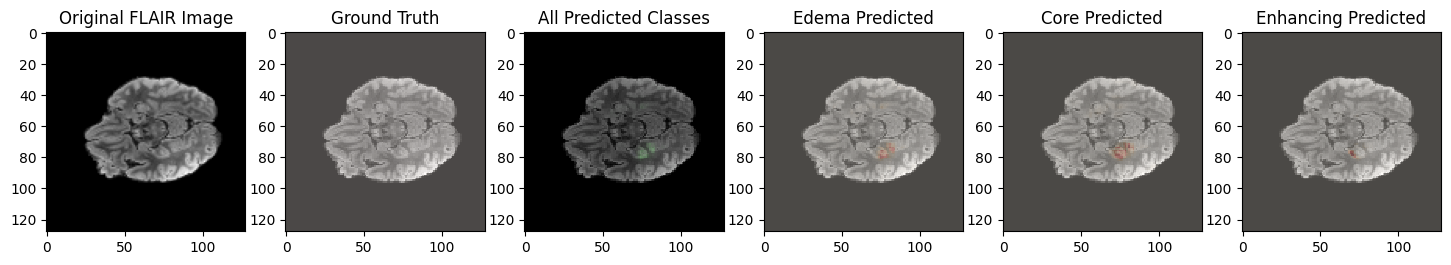

5/5 [==============================] - 1s 222ms/step


<Figure size 1800x5000 with 0 Axes>

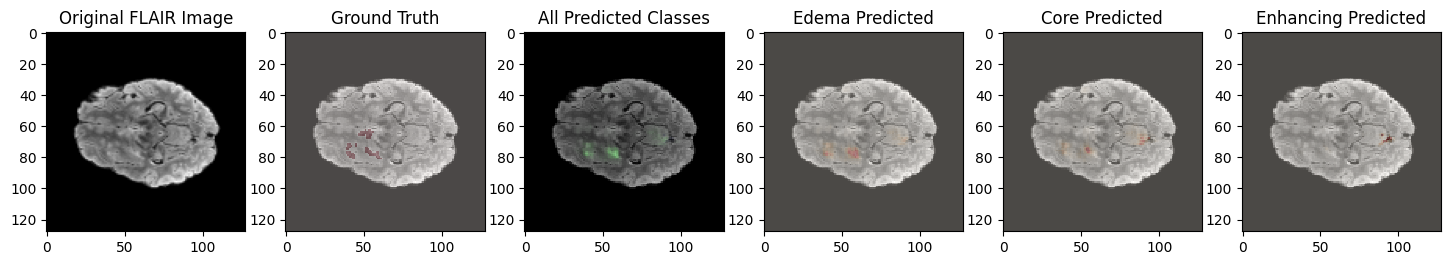

In [ ]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Constants
IMG_SIZE = 128
VOLUME_SLICES = 155  # Adjust this according to your dataset
VOLUME_START_AT = 0  # Adjust this if needed for your data
SEGMENT_CLASSES = {1: "Edema", 2: "Core", 3: "Enhancing"}  # Classes for segmentation

# Load the trained model
model = load_model('Models/Trained_CNN_Model.h5', compile=False)

# Function to preprocess and make predictions
def predict1(case_path, case):
    # Initialize an empty array for predictor with two channels (FLAIR and T1CE)
    predictor = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Load FLAIR and T1CE modalities
    flair_path = os.path.join('MRI', case_path, f'{case_path}_flair.nii')
    ce_path = os.path.join('MRI', case_path, f'{case_path}_t1ce.nii')

    flair = nib.load(flair_path).get_fdata()
    ce = nib.load(ce_path).get_fdata()

    # Process the slices for FLAIR and T1CE
    for j in range(VOLUME_SLICES):
        predictor[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        predictor[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    # Normalize the input
    predictor = predictor / np.max(predictor)

    # Make predictions using the model
    predictions = model.predict(predictor, verbose=1)
    return predictions

# Function to visualize predictions
def predict(case, case_folder, start_slice=60):
    case_path = case_folder

    # Load ground truth segmentation and original FLAIR image
    gt_path = os.path.join('MRI',case_path, f'{case_path}_seg.nii')
    flair_path = os.path.join('MRI',case_path, f'{case_path}_flair.nii')

    gt = nib.load(gt_path).get_fdata()
    original_image = nib.load(flair_path).get_fdata()

    # Get predictions from the model
    predictions = predict1(case_path, case)

    # Extract the predicted classes
    core = predictions[:, :, :, 1]  # Tumor core
    edema = predictions[:, :, :, 2]  # Edema
    enhancing = predictions[:, :, :, 3]  # Enhancing tumor

    # Create a subplot to visualize the results
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    for i in range(6):
        axarr[i].imshow(cv2.resize(original_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    # Original Image FLAIR
    axarr[0].imshow(cv2.resize(original_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original FLAIR Image')

    # Ground Truth
    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].title.set_text('Ground Truth')

    # All predicted classes
    axarr[2].imshow(predictions[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('All Predicted Classes')

    # Edema Prediction
    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} Predicted')

    # Core Prediction
    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} Predicted')

    # Enhancing Prediction
    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} Predicted')

    plt.show()

# Example usage: Visualize predictions for a specific patient case in MRI/ folder
patient_folder = "BraTS2021_00495"  # Adjust this to match your actual folder structure
predict(case="00495", case_folder=patient_folder, start_slice=60)

patient_folder = "BraTS2021_00621"  # Adjust this to match your actual folder structure
predict(case="00621", case_folder=patient_folder, start_slice=60)


5/5 [==============================] - 4s 793ms/step


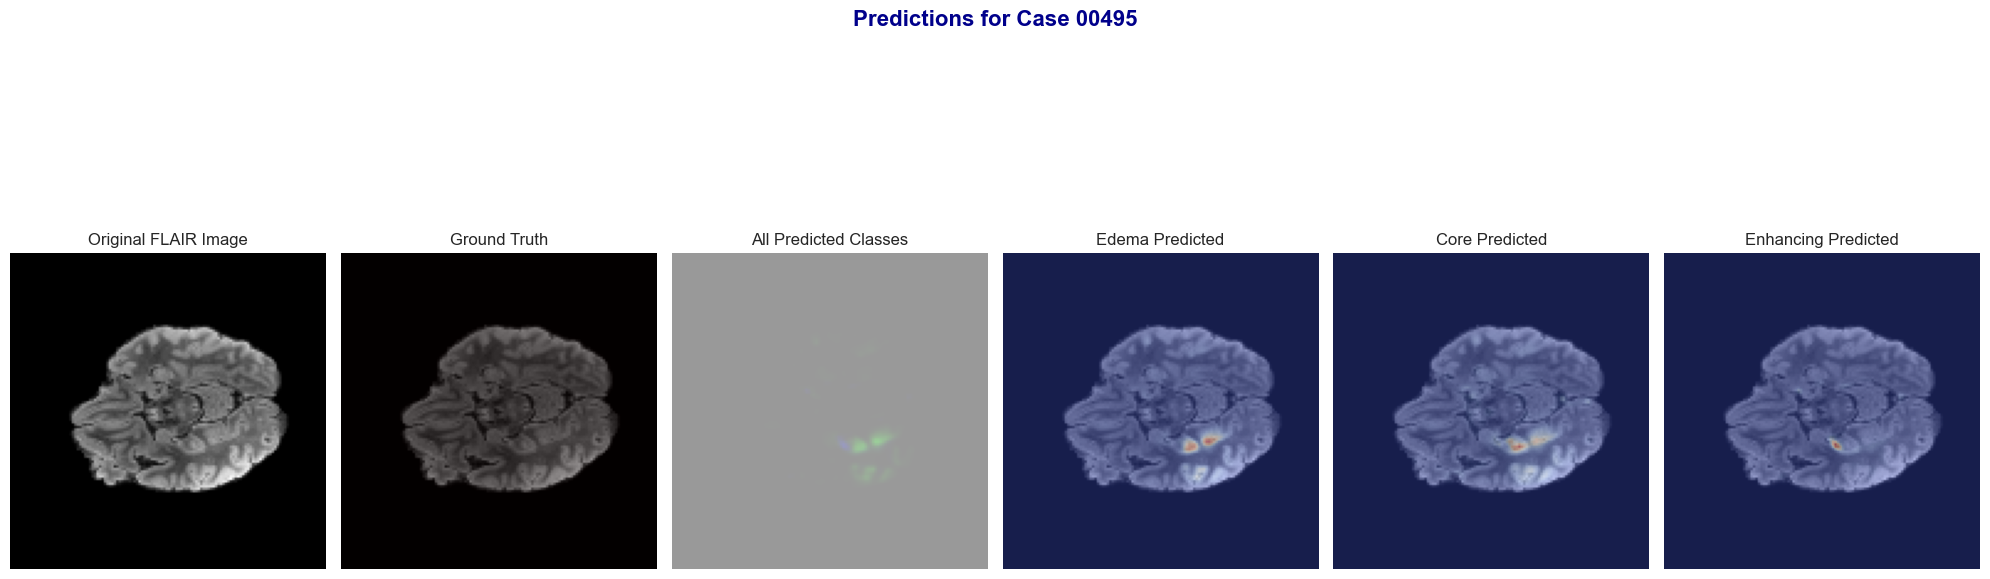

5/5 [==============================] - 4s 811ms/step


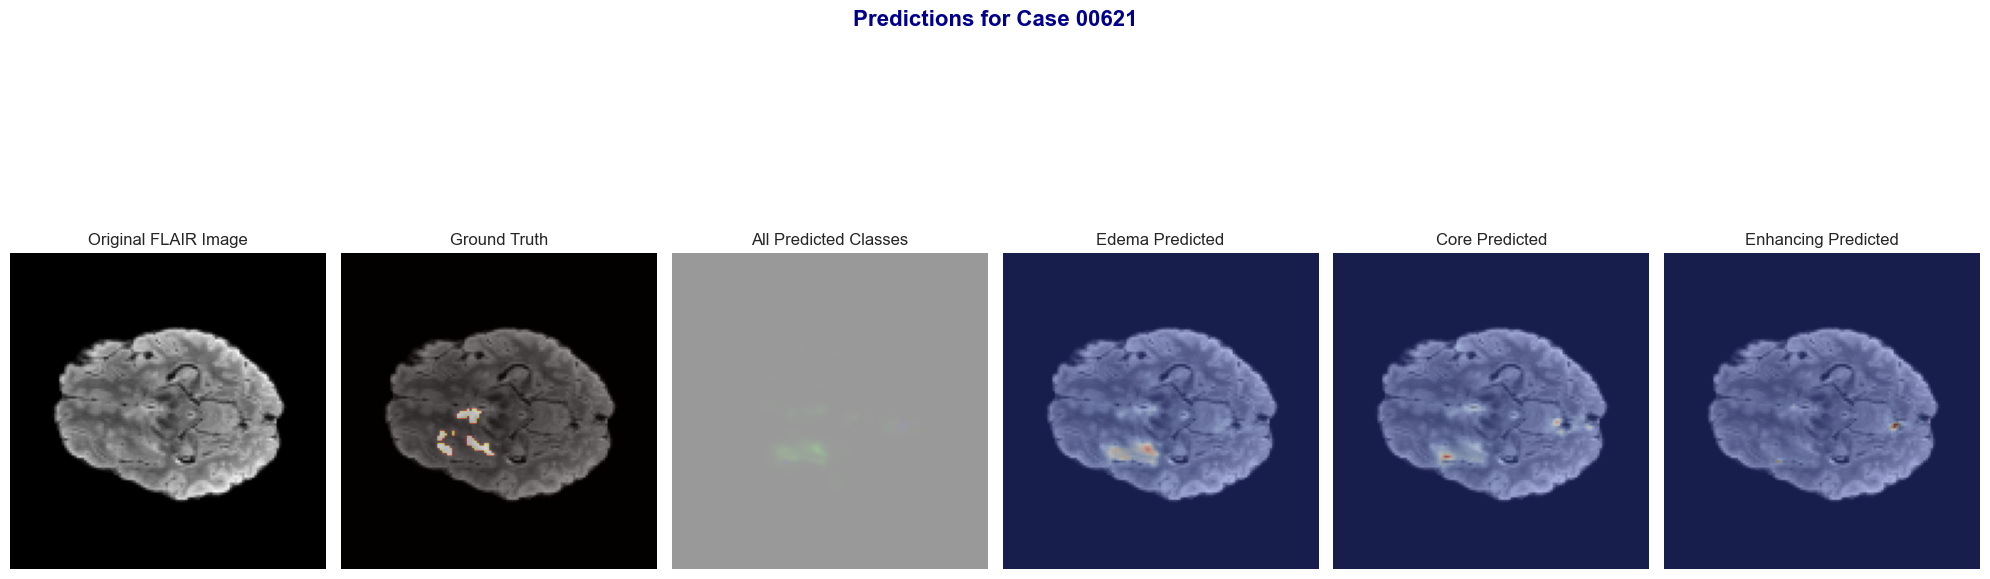

In [ ]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Constants
IMG_SIZE = 128
VOLUME_SLICES = 155  # Adjust this according to your dataset
VOLUME_START_AT = 0  # Adjust this if needed for your data
SEGMENT_CLASSES = {1: "Edema", 2: "Core", 3: "Enhancing"}  # Classes for segmentation

# Load the trained model
model = load_model('Models/Trained_CNN_Model.h5', compile=False)

# Function to preprocess and make predictions
def predict1(case_path, case):
    # Initialize an empty array for predictor with two channels (FLAIR and T1CE)
    predictor = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Load FLAIR and T1CE modalities
    flair_path = os.path.join('MRI', case_path, f'{case_path}_flair.nii')
    ce_path = os.path.join('MRI', case_path, f'{case_path}_t1ce.nii')

    flair = nib.load(flair_path).get_fdata()
    ce = nib.load(ce_path).get_fdata()

    # Process the slices for FLAIR and T1CE
    for j in range(VOLUME_SLICES):
        predictor[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        predictor[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    # Normalize the input
    predictor = predictor / np.max(predictor)

    # Make predictions using the model
    predictions = model.predict(predictor, verbose=1)
    return predictions

# Function to visualize predictions in a publication-ready style
def predict(case, case_folder, start_slice=60, save_fig=True):
    case_path = case_folder

    # Load ground truth segmentation and original FLAIR image
    gt_path = os.path.join('MRI', case_path, f'{case_path}_seg.nii')
    flair_path = os.path.join('MRI', case_path, f'{case_path}_flair.nii')

    gt = nib.load(gt_path).get_fdata()
    original_image = nib.load(flair_path).get_fdata()

    # Get predictions from the model
    predictions = predict1(case_path, case)

    # Extract the predicted classes
    core = predictions[:, :, :, 1]  # Tumor core
    edema = predictions[:, :, :, 2]  # Edema
    enhancing = predictions[:, :, :, 3]  # Enhancing tumor

    # Create a subplot to visualize the results
    fig, axarr = plt.subplots(1, 6, figsize=(20, 8))
    fig.suptitle(f'Predictions for Case {case}', fontsize=16, fontweight='bold', color='darkblue')

    # Apply a consistent color scheme and style for clarity
    cmap_pred = "coolwarm"  # Colormap for predicted regions
    cmap_truth = "hot"  # Colormap for ground truth regions
    alpha_overlay = 0.4  # Transparency for overlays

    # Original Image FLAIR
    axarr[0].imshow(cv2.resize(original_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original FLAIR Image')
    axarr[0].axis('off')

    # Ground Truth
    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(cv2.resize(original_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[1].imshow(curr_gt, cmap=cmap_truth, alpha=alpha_overlay)
    axarr[1].title.set_text('Ground Truth')
    axarr[1].axis('off')

    # All predicted classes
    axarr[2].imshow(predictions[start_slice, :, :, 1:4], cmap=cmap_pred, alpha=alpha_overlay)
    axarr[2].title.set_text('All Predicted Classes')
    axarr[2].axis('off')

    # Edema Prediction
    axarr[3].imshow(cv2.resize(original_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[3].imshow(edema[start_slice, :, :], cmap=cmap_pred, alpha=alpha_overlay)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} Predicted')
    axarr[3].axis('off')

    # Core Prediction
    axarr[4].imshow(cv2.resize(original_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[4].imshow(core[start_slice, :, :], cmap=cmap_pred, alpha=alpha_overlay)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} Predicted')
    axarr[4].axis('off')

    # Enhancing Prediction
    axarr[5].imshow(cv2.resize(original_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[5].imshow(enhancing[start_slice, :, :], cmap=cmap_pred, alpha=alpha_overlay)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} Predicted')
    axarr[5].axis('off')

    plt.tight_layout()

    # Save the figure as an image for use in research papers
    if save_fig:
        fig.savefig(f'vitUnetPrediction_case_{case}.png', bbox_inches='tight', dpi=300)
    
    plt.show()

# Example usage: Visualize predictions for a specific patient case in MRI/ folder
patient_folder = "BraTS2021_00495"  # Adjust this to match your actual folder structure
predict(case="00495", case_folder=patient_folder, start_slice=60)

patient_folder = "BraTS2021_00621"  # Adjust this to match your actual folder structure
predict(case="00621", case_folder=patient_folder, start_slice=60)


Batch ['BraTS2021_01549']
Case Path: Data/BraTS2021/BraTS2021_01549/BraTS2021_01549
Processed patient: 0
5/5 [==============================] - 1s 225ms/step
Batch ['BraTS2021_01542']
Case Path: Data/BraTS2021/BraTS2021_01542/BraTS2021_01542
Processed patient: 0
5/5 [==============================] - 1s 230ms/step
Batch ['BraTS2021_01569']
Case Path: Data/BraTS2021/BraTS2021_01569/BraTS2021_01569
Processed patient: 0
5/5 [==============================] - 1s 226ms/step
Batch ['BraTS2021_01043']
Case Path: Data/BraTS2021/BraTS2021_01043/BraTS2021_01043
Processed patient: 0
5/5 [==============================] - 1s 233ms/step
Batch ['BraTS2021_01659']
Case Path: Data/BraTS2021/BraTS2021_01659/BraTS2021_01659
Processed patient: 0
5/5 [==============================] - 1s 232ms/step
Batch ['BraTS2021_01586']
Case Path: Data/BraTS2021/BraTS2021_01586/BraTS2021_01586
Processed patient: 0
5/5 [==============================] - 1s 237ms/step
Batch ['BraTS2021_00483']
Case Path: Data/BraTS2021/

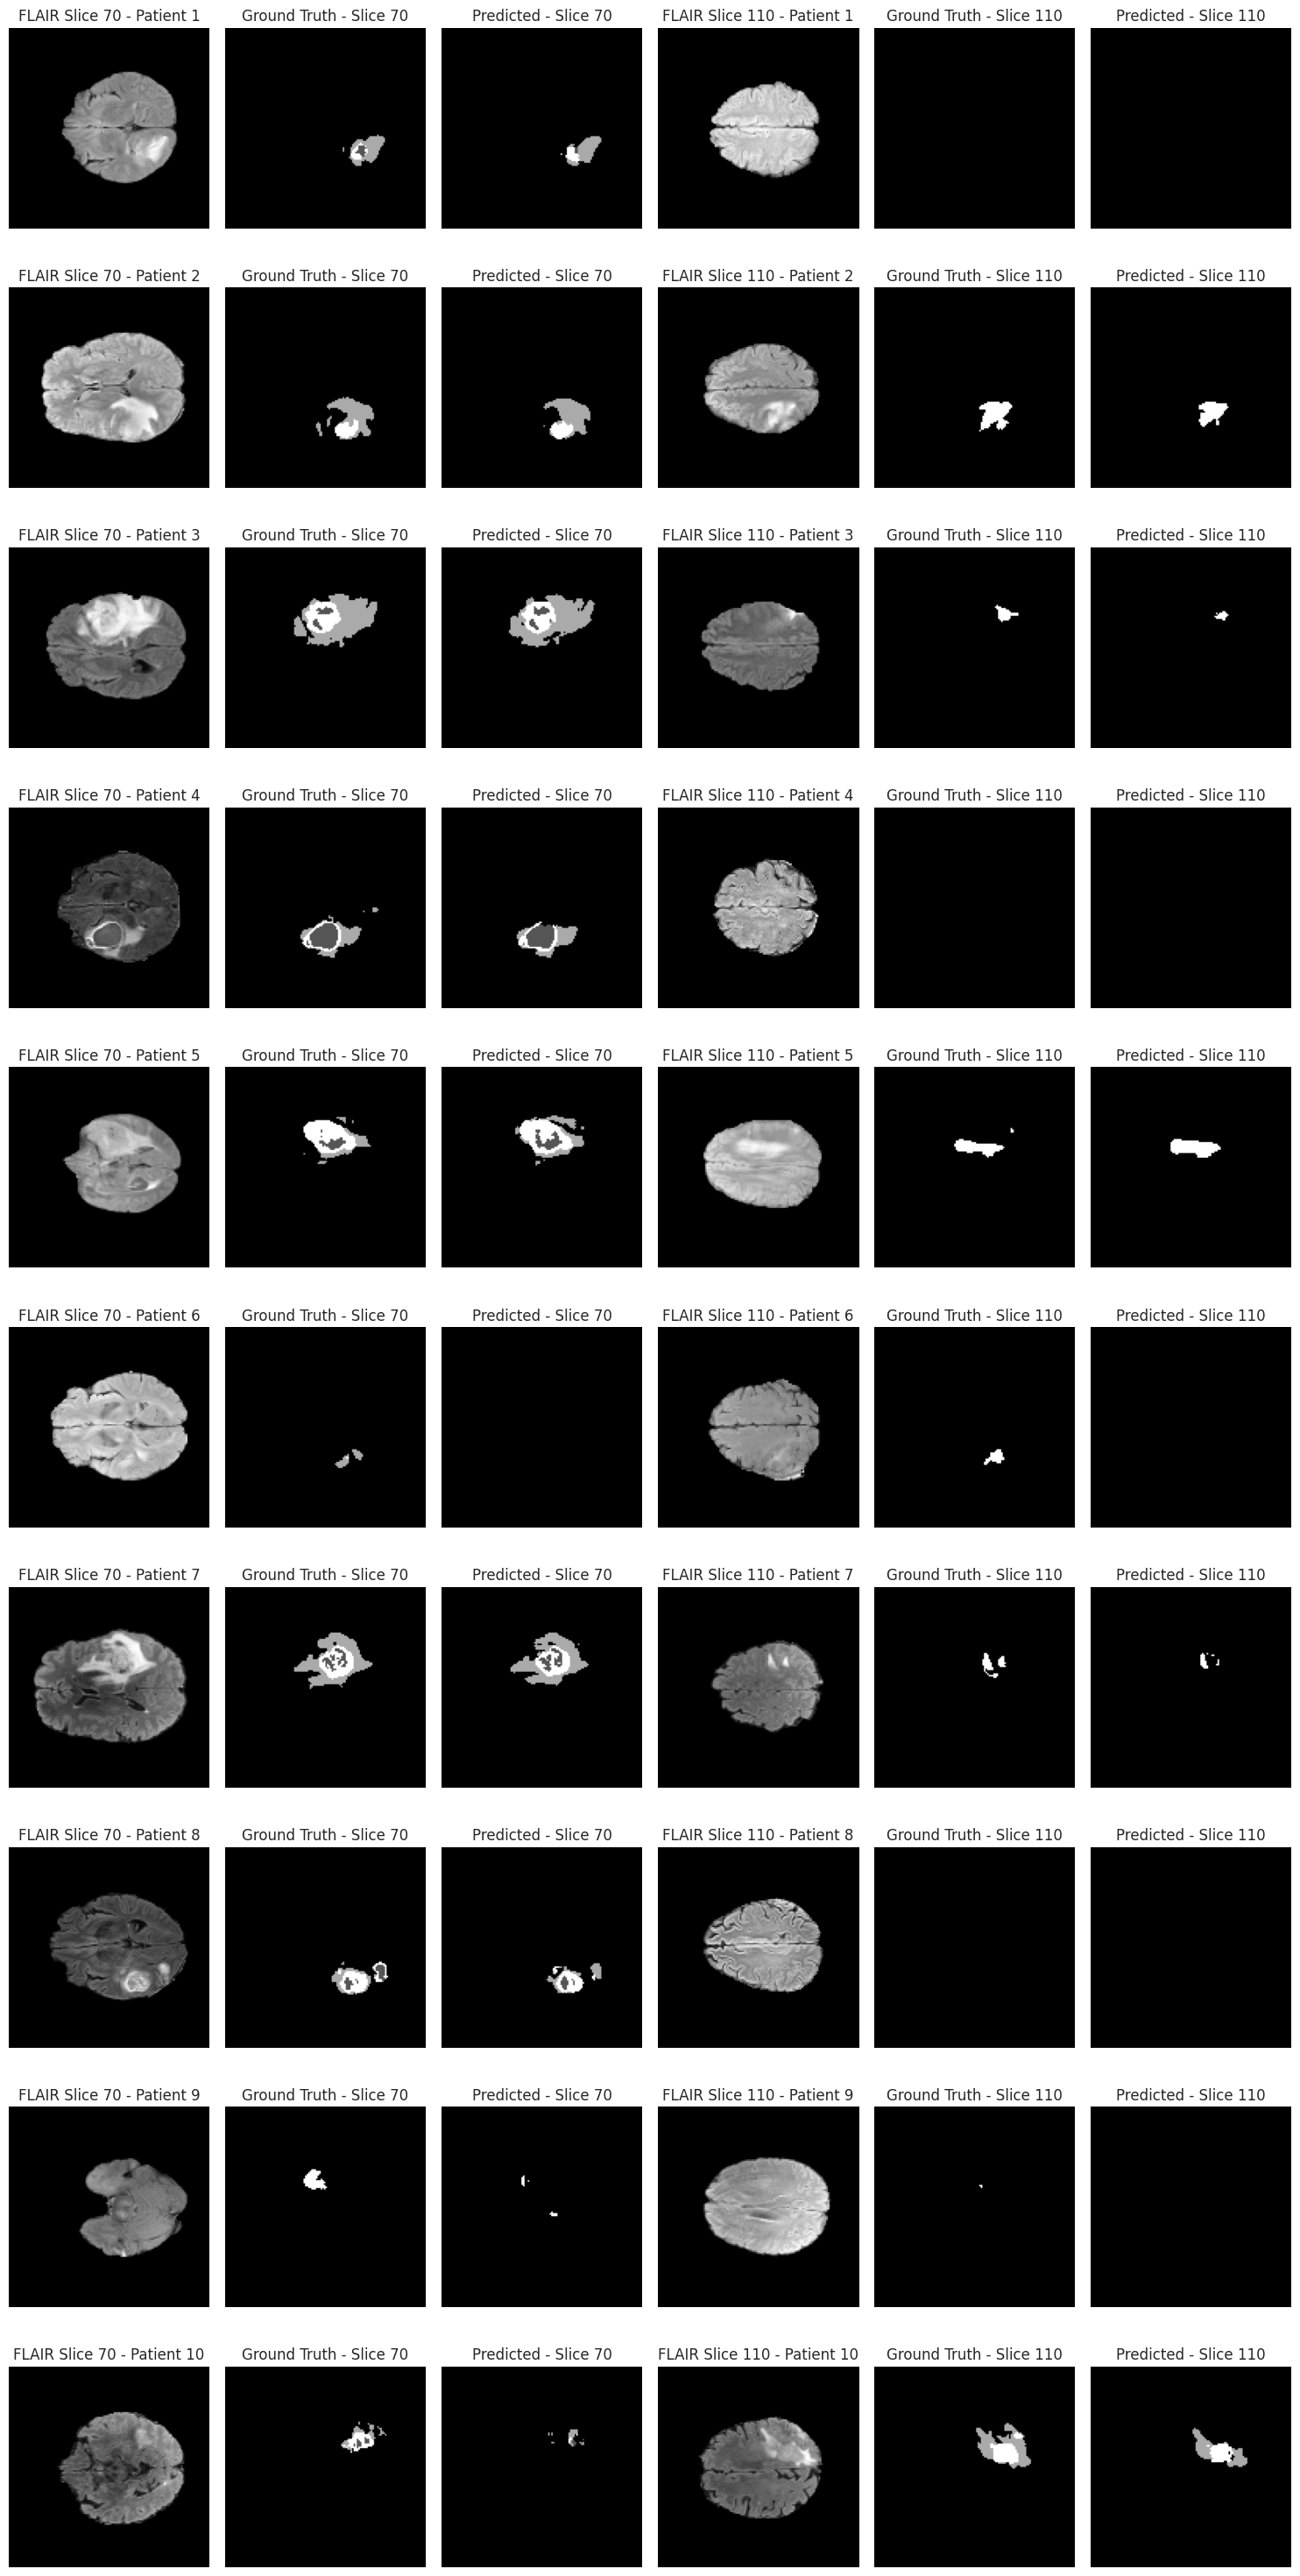

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure the test generator is already initialized
# Assumes test_generator is a DataGenerator instance with test files

# Load the saved model
model_with_ViT = tf.keras.models.load_model('Models/Trained_CNN_Model.h5', compile=False)

# Define specific slices to visualize
slice_indices = [70, 110]

# Function to get a batch from the test generator and make predictions on specific slices
def get_random_test_samples(test_generator, num_samples=10, slice_indices=slice_indices):
    # Randomly select patient indices
    selected_indices = random.sample(range(len(test_generator)), num_samples)
    
    X_samples = []
    Y_true_samples = []
    Y_pred_samples = []
    
    for idx in selected_indices:
        X, Y_true = test_generator[idx]  # Get batch data
        Y_pred = model_with_ViT.predict(X)  # Make prediction on this batch
        
        # Select specified slices from this patient's scan
        X_slices = [X[slice_idx] for slice_idx in slice_indices]
        Y_true_slices = [Y_true[slice_idx] for slice_idx in slice_indices]
        Y_pred_slices = [Y_pred[slice_idx] for slice_idx in slice_indices]
        
        X_samples.append(X_slices)
        Y_true_samples.append(Y_true_slices)
        Y_pred_samples.append(Y_pred_slices)
    
    return X_samples, Y_true_samples, Y_pred_samples

# Fetch random samples with 2 specific slices per patient
X_samples, Y_true_samples, Y_pred_samples = get_random_test_samples(test_generator, num_samples=10, slice_indices=slice_indices)

# Set up the grid for visualization
fig, axes = plt.subplots(10, 2 * 3, figsize=(15, 30))  # 10 rows for patients, 3 columns per slice (Input, Ground Truth, Prediction)

for i in range(10):  # For each patient
    for j in range(2):  # For each selected slice (2 slices per patient)
        # Display the input FLAIR image for the selected slice
        axes[i, j * 3].imshow(X_samples[i][j][:, :, 0], cmap='gray')
        axes[i, j * 3].set_title(f'FLAIR Slice {slice_indices[j]} - Patient {i+1}')
        axes[i, j * 3].axis('off')
        
        # Display the ground truth mask for the selected slice
        true_mask = np.argmax(Y_true_samples[i][j], axis=-1)  # Convert one-hot to mask
        axes[i, j * 3 + 1].imshow(true_mask, cmap='gray')
        axes[i, j * 3 + 1].set_title(f'Ground Truth - Slice {slice_indices[j]}')
        axes[i, j * 3 + 1].axis('off')
        
        # Display the predicted mask for the selected slice
        pred_mask = np.argmax(Y_pred_samples[i][j], axis=-1)  # Convert one-hot to mask
        axes[i, j * 3 + 2].imshow(pred_mask, cmap='gray')
        axes[i, j * 3 + 2].set_title(f'Predicted - Slice {slice_indices[j]}')
        axes[i, j * 3 + 2].axis('off')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('Visualization/Multiple_Patients_2_Slices_Prediction_Overview.png', bbox_inches='tight', dpi=300)
plt.show()


Processing BraTS2021_00621...
5/5 [==============================] - 1s 222ms/step
Processing BraTS2021_00495...
5/5 [==============================] - 1s 225ms/step


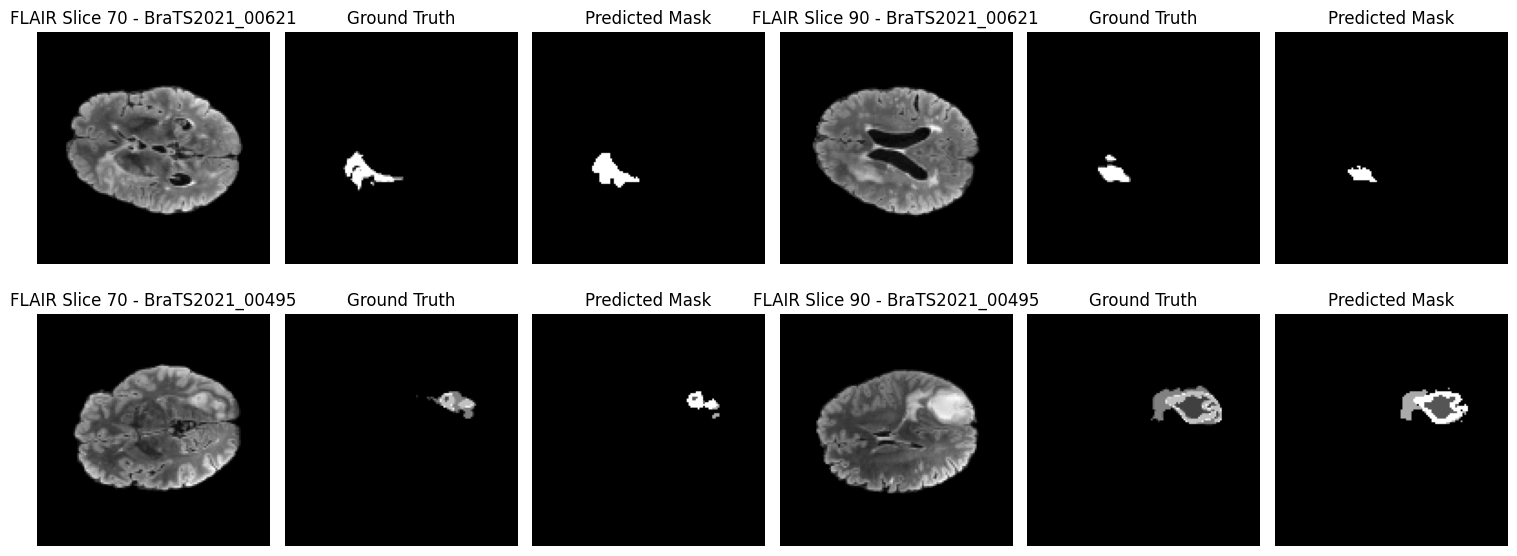

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import nibabel as nib

# Define constants
IMG_SIZE = 128
VOLUME_SLICES = 155  # Maximum number of slices per volume
n_channels = 2  # Number of MRI channels (e.g., FLAIR, T1CE)
slice_indices = [70, 90]  # Slices to visualize
mri_folder = 'MRI'  # Folder containing patient data

# Load the saved model
model_with_ViT = load_model('Models/Trained_CNN_Model.h5', compile=False)

# Function to load patient data
def load_patient_data(patient_folder):
    X = np.zeros((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, n_channels))
    Y = np.zeros((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))  # Ground truth

    # Load each modality (FLAIR, T1CE)
    flair_path = os.path.join(mri_folder, patient_folder, f'{patient_folder}_flair.nii')
    t1ce_path = os.path.join(mri_folder, patient_folder, f'{patient_folder}_t1ce.nii')
    seg_path = os.path.join(mri_folder, patient_folder, f'{patient_folder}_seg.nii')

    flair = nib.load(flair_path).get_fdata()
    t1ce = nib.load(t1ce_path).get_fdata()
    seg = nib.load(seg_path).get_fdata()

    total_slices = flair.shape[2]  # Number of available slices

    # Resize and load data into X and Y arrays
    for j in range(min(VOLUME_SLICES, total_slices)):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(t1ce[:, :, j], (IMG_SIZE, IMG_SIZE))
        Y[j] = cv2.resize(seg[:, :, j], (IMG_SIZE, IMG_SIZE))

    # Normalize inputs
    X = X / (np.max(X) + 1e-8)

    # Adjust labels for segmentation
    Y[Y == 4] = 3  # Adjust class values if needed

    return X, Y

# Get all patient folders in the MRI directory
patient_folders = [f for f in os.listdir(mri_folder) if os.path.isdir(os.path.join(mri_folder, f))]

# Set up the grid: each row corresponds to one patient, each patient has 2 slices (input, ground truth, prediction)
fig, axes = plt.subplots(len(patient_folders), len(slice_indices) * 3, figsize=(15, len(patient_folders) * 3))

for i, patient_folder in enumerate(patient_folders):
    print(f"Processing {patient_folder}...")

    # Load patient data
    patient_data, ground_truth = load_patient_data(patient_folder)

    # Make prediction on the entire volume
    prediction = model_with_ViT.predict(patient_data)

    for j, slice_num in enumerate(slice_indices):
        # Display the FLAIR input image for the selected slice
        axes[i, j * 3].imshow(patient_data[slice_num, :, :, 0], cmap='gray')
        axes[i, j * 3].set_title(f'FLAIR Slice {slice_num} - {patient_folder}')
        axes[i, j * 3].axis('off')

        # Display the ground truth mask for the selected slice
        true_mask = ground_truth[slice_num]
        axes[i, j * 3 + 1].imshow(true_mask, cmap='gray')
        axes[i, j * 3 + 1].set_title('Ground Truth')
        axes[i, j * 3 + 1].axis('off')

        # Display the predicted mask for the selected slice
        pred_mask = np.argmax(prediction[slice_num], axis=-1)  # Convert one-hot to mask
        axes[i, j * 3 + 2].imshow(pred_mask, cmap='gray')
        axes[i, j * 3 + 2].set_title('Predicted Mask')
        axes[i, j * 3 + 2].axis('off')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('Visualization/All_Patients_2_Slices_Prediction_Overview.png', bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

# Load the trained model
model_with_ViT = load_model('Models/Trained_CNN_Model.h5', compile=False)

# Initialize test generator
# Assumes test_generator is already defined and initialized with test data

# Get true labels and model predictions
y_true = []
y_scores = []

for i in range(len(test_generator)):
    X, Y = test_generator[i]
    Y_pred = model_with_ViT.predict(X)
    
    # Convert Tensors to NumPy arrays and flatten for ROC analysis
    y_true.append(Y.numpy().reshape(-1, Y.shape[-1]))  # Flatten and keep each class in a separate column
    y_scores.append(Y_pred.reshape(-1, Y_pred.shape[-1]))  # Flatten and keep each class in a separate column

# Concatenate all batches
y_true = np.concatenate(y_true, axis=0)
y_scores = np.concatenate(y_scores, axis=0)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(y_true.shape[1]):  # Iterate over each class
    # Binarize true labels and scores for the current class
    y_true_class = y_true[:, i]
    y_scores_class = y_scores[:, i]

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true_class, y_scores_class)
    roc_auc = auc(fpr, tpr)

    # Plot ROC for the current class
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {roc_auc:.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], 'r--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Batch ['BraTS2021_01527']
Case Path: Data/BraTS2021/BraTS2021_01527/BraTS2021_01527
Processed patient: 0
5/5 [==============================] - 1s 225ms/step
Batch ['BraTS2021_00507']
Case Path: Data/BraTS2021/BraTS2021_00507/BraTS2021_00507
Processed patient: 0
5/5 [==============================] - 1s 227ms/step
Batch ['BraTS2021_01561']
Case Path: Data/BraTS2021/BraTS2021_01561/BraTS2021_01561
Processed patient: 0
5/5 [==============================] - 1s 224ms/step
Batch ['BraTS2021_00003']
Case Path: Data/BraTS2021/BraTS2021_00003/BraTS2021_00003
Processed patient: 0
5/5 [==============================] - 1s 231ms/step
Batch ['BraTS2021_01471']
Case Path: Data/BraTS2021/BraTS2021_01471/BraTS2021_01471
Processed patient: 0
5/5 [==============================] - 1s 223ms/step
Batch ['BraTS2021_01389']
Case Path: Data/BraTS2021/BraTS2021_01389/BraTS2021_01389
Processed patient: 0
5/5 [==============================] - 1s 226ms/step
Batch ['BraTS2021_00782']
Case Path: Data/BraTS2021/

ValueError: continuous format is not supported

<Figure size 1000x800 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



# Compute the confusion matrix
cm = np.zeros((4, 4))
for i in range(len(true_labels)):
    cm[true_labels[i], pred_labels[i]] += 1

# Plot the confusion matrix
class_names = ['NOT tumor', 'NECROTIC/CORE', 'EDEMA', 'ENHANCING']
plot_confusion_matrix(cm, classes=class_names, title='Brain Tumor Segmentation Confusion Matrix')
plt.show()
